In [18]:
import os
import cv2
import numpy as np
from skimage import feature
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# plt.style.use("seaborn-whitegrid")
# plt.rc("figure", autolayout=True)
# plt.rc(
#     "axes",
#     labelweight="bold",
#     labelsize="large",
#     titleweight="bold",
#     titlesize=14,
#     titlepad=10,
# )

In [20]:
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
    return features

In [21]:
def load_split(path):
    # grab the list of images in the input directory, then initialize
    # the list of data (i.e., images) and class labels
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]
        # load the input image, convert it to grayscale, and resize
        # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        # threshold the image such that the drawing appears as white
        # on a black background
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image
        features = quantify_image(image)
        # update the data and labels lists, respectively
        data.append(features)
        labels.append(label)
    return (np.array(data), np.array(labels))

# Training model

In [22]:
# !pip install imutils
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [23]:
def train_models(dataset):
    # initialize the models
    models = {
        "Rf": {
            "classifier": RandomForestClassifier(random_state=1),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        },
        "Xgb": {
            "classifier": XGBClassifier(),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        }
    }
    # define the path to the testing and training directories
    path = "./" + dataset
    trainingPath = os.path.sep.join([path, "training"])
    testingPath = os.path.sep.join([path, "testing"])
    # load the data
    (trainX, trainY) = load_split(trainingPath)
    (testX, testY) = load_split(testingPath)
    # encode the labels
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)

    # train each model and calculate its metrics
    for model in models:
        models[model]["classifier"].fit(trainX, trainY)
        predictions = models[model]["classifier"].predict(testX)
        cm = confusion_matrix(testY, predictions).ravel()
        tn, fp, fn, tp = cm
        models[model]["accuracy"] = (tp + tn) / float(cm.sum())
        models[model]["sensitivity"] = tp / float(tp + fn)
        models[model]["specificity"] = tn / float(tn + fp)

    return models

### Train Spiral Model

In [24]:
spiralModels = train_models('spiral')

c:\python\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:51:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Train Wave Model

In [25]:
waveModels = train_models('wave')

c:\python\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:51:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# Model preformance 

#### Spiral performance

In [26]:
print("Random Forrest vs XGBoost Classifier\n\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        spiralModels['Rf'][metric]*100, spiralModels['Xgb'][metric]*100))

Random Forrest vs XGBoost Classifier


Accuracy: 
Random Forrest=83.33%, XGBoost=73.33% 

Sensitivity: 
Random Forrest=80.00%, XGBoost=73.33% 

Specificity: 
Random Forrest=86.67%, XGBoost=73.33% 



#### Wave performance

In [27]:
print("Random Forrest vs XGBoost Classifier\n\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        waveModels['Rf'][metric]*100, waveModels['Xgb'][metric]*100))

Random Forrest vs XGBoost Classifier


Accuracy: 
Random Forrest=76.67%, XGBoost=70.00% 

Sensitivity: 
Random Forrest=73.33%, XGBoost=73.33% 

Specificity: 
Random Forrest=80.00%, XGBoost=66.67% 



### Testing

In [28]:
def test_prediction(model, testingPath):
    # get the list of images
    testingPaths = list(paths.list_images(testingPath))
    output_images = []
    # pick 15 images at random
    for _ in range(15):
        image = cv2.imread(random.choice(testingPaths))
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # pre-process the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image and make predictions based on the extracted features
        features = quantify_image(image)
        preds = model.predict([features])
        label = "Parkinsons" if preds[0] else "Healthy"

        # draw the colored class label on the output image and add it to
        # the set of output images
        color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
        output_images.append(output)
    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()

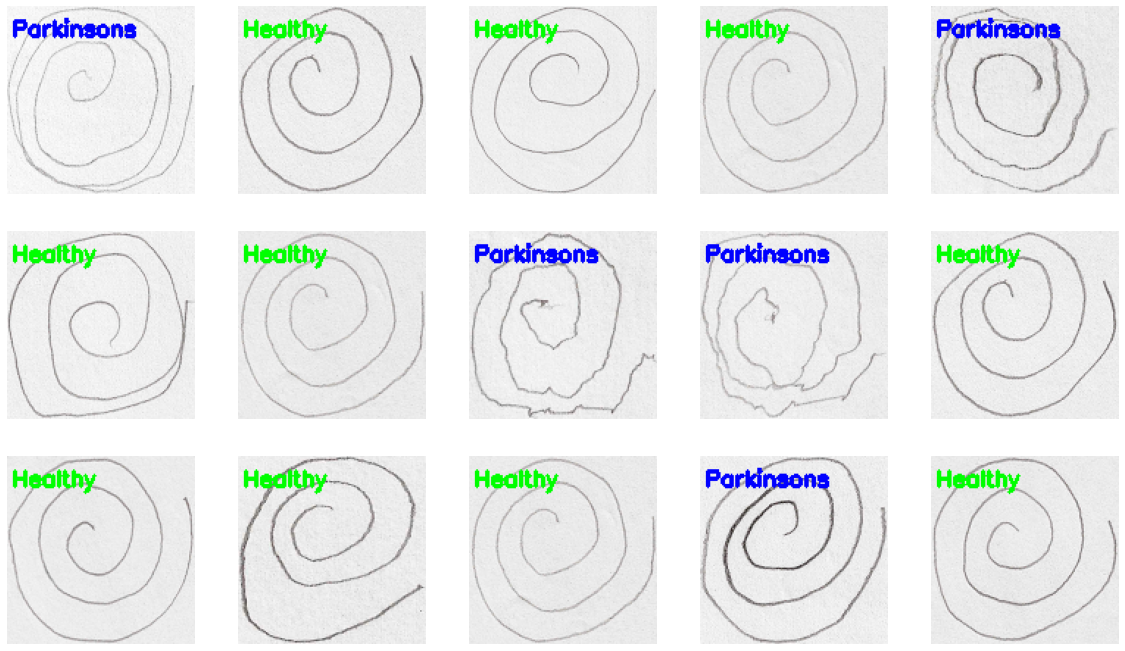

In [29]:
testingPath = os.path.sep.join(["./spiral", "testing"])
test_prediction(spiralModels['Rf']['classifier'], testingPath)

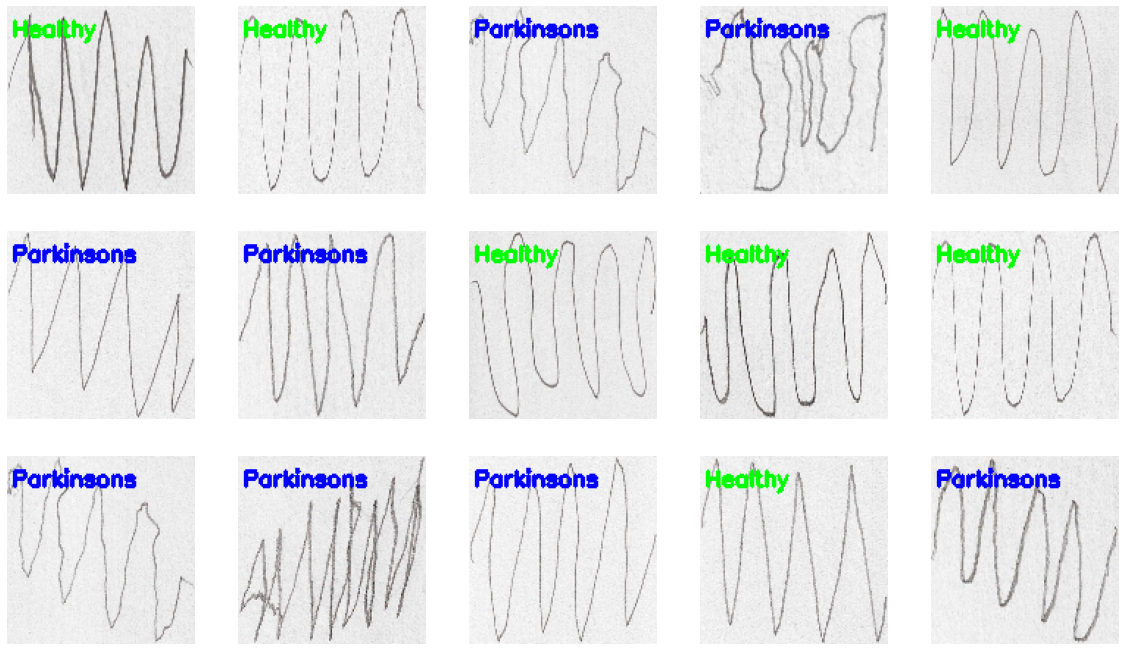

In [30]:
testingPath = os.path.sep.join(["./wave", "testing"])
test_prediction(waveModels['Rf']['classifier'], testingPath)

In [31]:
# df_test = pd.read_csv('/content/test.csv')
# df_train = pd.read_csv('/content/train.csv')

In [32]:
def predication(image_list,spiralModels,waveModels):
    # image_list=[[image,type],[image,type]]

    result =[]
    for image_id,image,type in image_list:
        # image = cv2.imread(random.choice(testingPaths))
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # print(output)
        # pre-process the image
        output = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
        output = cv2.resize(output, (200, 200))
        output = cv2.threshold(output, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    #     # # quantify the image and make predictions based on the extracted features
        features = quantify_image(output)
        pred=0
        if type == 'spiral':
            pred = spiralModels['Rf']['classifier'].predict([features])
        elif type == 'wave':
            pred = waveModels['Rf']['classifier'].predict([features])
        else:
            return print('Type Error')

        result.append([image_id,type,pred[0]])

    #     #
    #     # # draw the colored class label on the output image and add it to
    #     # # the set of output images
    #     # color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
    #     # cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
    #     #             color, 2)
    #     # output_images.append(output)

    #
    # plt.figure(figsize=(20, 20))
    # for i in range(len(result)):
    #     plt.subplot(5, 5, i+1)
    #     plt.imshow(result[i][1])
    #     plt.axis("off")
    # plt.show()

    return result

In [33]:
testingPath = os.path.sep.join(["./wave", "testing"])

In [34]:
testingPaths_1 = list(paths.list_images(testingPath))

In [35]:
testingPaths_1

['./wave\\testing\\healthy\\V01HO01.png',
 './wave\\testing\\healthy\\V02HO01.png',
 './wave\\testing\\healthy\\V03HO01.png',
 './wave\\testing\\healthy\\V04HO01.png',
 './wave\\testing\\healthy\\V05HO01.png',
 './wave\\testing\\healthy\\V06HO01.png',
 './wave\\testing\\healthy\\V07HO01.png',
 './wave\\testing\\healthy\\V08HO01.png',
 './wave\\testing\\healthy\\V09HO01.png',
 './wave\\testing\\healthy\\V10HO01.png',
 './wave\\testing\\healthy\\V11HO01.png',
 './wave\\testing\\healthy\\V55HO08.png',
 './wave\\testing\\healthy\\V55HO09.png',
 './wave\\testing\\healthy\\V55HO10.png',
 './wave\\testing\\healthy\\V55HO11.png',
 './wave\\testing\\parkinson\\V01PO01.png',
 './wave\\testing\\parkinson\\V02PO01.png',
 './wave\\testing\\parkinson\\V03PO01.png',
 './wave\\testing\\parkinson\\V03PO04.png',
 './wave\\testing\\parkinson\\V03PO07.png',
 './wave\\testing\\parkinson\\V04PO01.png',
 './wave\\testing\\parkinson\\V05PO01.png',
 './wave\\testing\\parkinson\\V06PO01.png',
 './wave\\testing\

In [45]:
def read(testing_paths):
    # if len(testing_paths)>15:
    #     return print("Keep the data less than 15")

    # print(testing_paths)
    image_list=[]
    for i in range(len(testing_paths)):
        if i>3:
            break
        image = cv2.imread(testing_paths[i])
        image_list.append([i,image,'wave'])

    return image_list

In [46]:
testingPaths_1

['./wave\\testing\\healthy\\V01HO01.png',
 './wave\\testing\\healthy\\V02HO01.png',
 './wave\\testing\\healthy\\V03HO01.png',
 './wave\\testing\\healthy\\V04HO01.png',
 './wave\\testing\\healthy\\V05HO01.png',
 './wave\\testing\\healthy\\V06HO01.png',
 './wave\\testing\\healthy\\V07HO01.png',
 './wave\\testing\\healthy\\V08HO01.png',
 './wave\\testing\\healthy\\V09HO01.png',
 './wave\\testing\\healthy\\V10HO01.png',
 './wave\\testing\\healthy\\V11HO01.png',
 './wave\\testing\\healthy\\V55HO08.png',
 './wave\\testing\\healthy\\V55HO09.png',
 './wave\\testing\\healthy\\V55HO10.png',
 './wave\\testing\\healthy\\V55HO11.png',
 './wave\\testing\\parkinson\\V01PO01.png',
 './wave\\testing\\parkinson\\V02PO01.png',
 './wave\\testing\\parkinson\\V03PO01.png',
 './wave\\testing\\parkinson\\V03PO04.png',
 './wave\\testing\\parkinson\\V03PO07.png',
 './wave\\testing\\parkinson\\V04PO01.png',
 './wave\\testing\\parkinson\\V05PO01.png',
 './wave\\testing\\parkinson\\V06PO01.png',
 './wave\\testing\

In [47]:
image_list = read(testingPaths_1)

In [48]:
print(image_list)

[[0, array([[[234, 234, 234],
        [239, 239, 239],
        [238, 238, 238],
        ...,
        [236, 236, 236],
        [237, 237, 237],
        [247, 247, 247]],

       [[239, 239, 239],
        [245, 245, 245],
        [231, 231, 231],
        ...,
        [235, 235, 235],
        [237, 237, 237],
        [246, 246, 246]],

       [[245, 245, 245],
        [250, 250, 250],
        [246, 246, 246],
        ...,
        [239, 239, 239],
        [243, 243, 243],
        [241, 241, 241]],

       ...,

       [[250, 250, 250],
        [243, 243, 243],
        [239, 239, 239],
        ...,
        [223, 223, 223],
        [222, 222, 222],
        [236, 236, 236]],

       [[242, 242, 242],
        [243, 243, 243],
        [244, 244, 244],
        ...,
        [237, 237, 237],
        [231, 231, 231],
        [238, 238, 238]],

       [[231, 231, 231],
        [240, 240, 240],
        [246, 246, 246],
        ...,
        [237, 237, 237],
        [234, 234, 234],
        [239, 239, 

In [49]:
result_images =predication(image_list,spiralModels,waveModels)

In [50]:
result_images

[[0, 'wave', 0], [1, 'wave', 0], [2, 'wave', 0], [3, 'wave', 0]]

result_images

In [42]:
from joblib import dump, load

In [43]:
dump(spiralModels, 'spiralModels.joblib')

['spiralModels.joblib']

In [44]:
dump(waveModels, 'waveModels.joblib')

['waveModels.joblib']